In [56]:
import numpy as np
import pandas as pd

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df_train = pd.read_parquet('./train.parq')

In [ ]:
# Eliminar duplicados
#df_train.drop_duplicates(inplace=True)

In [ ]:
# Guardar el dataset en un archivo parquet
#df_train.to_parquet('./train.parq', index=False)

# Visualizaciones

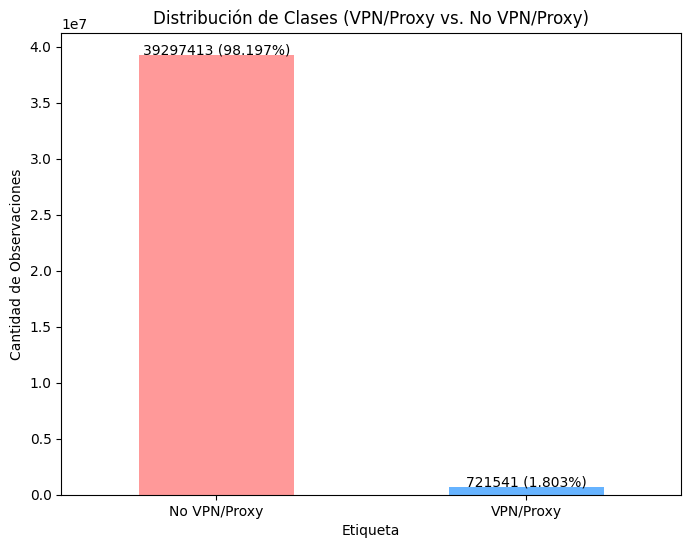

In [ ]:
class_counts = df_train['label'].value_counts()

# Crear un gráfico de barras apiladas con colores atractivos
fig, ax = plt.subplots(figsize=(8, 6))

# Definir colores para las clases
colors = ['#ff9999', '#66b3ff']

# Crear el gráfico de barras apiladas
class_counts.plot(kind='bar', ax=ax, color=colors, width=0.5)

# Personalizar el gráfico
ax.set_title("Distribución de Clases (VPN/Proxy vs. No VPN/Proxy)")
ax.set_xlabel("Etiqueta")
ax.set_ylabel("Cantidad de Observaciones")
ax.set_xticklabels(["No VPN/Proxy", "VPN/Proxy"], rotation=0)

# Agregar porcentajes en las barras
total = class_counts.sum()
for i, count in enumerate(class_counts):
    ax.text(i, count + 500, f'{count} ({count/total*100:.3f}%)', ha='center')

plt.show()

# Analisis Exploratorio de Datos

In [ ]:
df_train.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:exploit,2,4637,0


In [85]:
# Cantidad de valores nulos por columna mayores a cero
df_train.isnull().sum()[df_train.isnull().sum() > 0]

watcher_country     206262
watcher_as_name     206275
attacker_country     29262
attacker_as_num        414
attacker_as_name     44843
dtype: int64

# Imputacion

El data set se encuentra desbalanceado. La columna `label` tiene 2 valores posibles: 0 y 1 (VPN/proxy). La cantidad de 0 es mucho mayor que la cantidad de 1.

Se eliminaran los registros con valores nulos y que tengan un valor de `label` igual a 0.


## `watcher_country`

In [19]:
df_train = df_train[df_train["watcher_country"].notna() | df_train["label"] == 1]

In [52]:
df_train = df_train[df_train["watcher_as_name"].notna() | df_train["label"] == 1]

In [53]:
# Catidad de valores nulos por columna mayores a cero
df_train.isnull().sum()[df_train.isnull().sum() > 0]

watcher_country     4303
watcher_as_name     4303
attacker_country     502
attacker_as_num       17
attacker_as_name     101
dtype: int64

## `watcher_as_num`

In [8]:
df_train["watcher_as_num"].value_counts()

watcher_as_num
16276.0     2682659
24940.0     2245665
14061.0     1965080
396982.0    1678949
8560.0      1410876
             ...   
205718.0          1
51873.0           1
23473.0           1
19133.0           1
60609.0           1
Name: count, Length: 2914, dtype: int64

## `watcher_as_name`

In [9]:
df_train["watcher_as_name"].value_counts() 

watcher_as_name
OVH SAS                       2690097
Hetzner Online GmbH           2334040
DIGITALOCEAN-ASN              1965080
GOOGLE-CLOUD-PLATFORM         1678949
IONOS SE                      1410876
                               ...   
Virtual1 Limited                    1
Nine Internet Solutions AG          1
Nomotech SAS                        1
OEC-FIBER                           1
UAB Airnet                          1
Name: count, Length: 2770, dtype: int64

## `watcher_uuid_enum`

In [27]:
id = df_train["watcher_uuid_enum"].value_counts() 

## Imputacion simple `watcher_as_name`

- watcher_uuid_enum: El ID único del observador
  - watcher_country:
  - watcher_as_num:
  - watcher_as_name:

Un mismo 'ID' tiene los tres valores iguales. Por lo tanto, se puede imputar los valores faltantes de `watcher_as_name` y `watcher_country` con los valores de un mismo `watcher_uuid_enum`.

In [94]:
cols_to_impute = ["watcher_country", "watcher_as_name"]

In [95]:
df_train[cols_to_impute] = df_train.groupby("watcher_uuid_enum")[cols_to_impute].transform(lambda x: x.ffill().bfill())

In [96]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

watcher_country      2364
watcher_as_name      2395
attacker_country      502
attacker_as_num       206
attacker_as_name    40917
dtype: int64

## `watcher_uuid_enum`

`watcher_uuid_enum`: El ID único del observador.

- `watcher_country`: El país vinculado a la dirección IP del observador.
- `watcher_as_num`: El número de sistema autónomo (AS) vinculado a la dirección IP del observador.
- `watcher_as_name`: El nombre del sistema autónomo (AS) vinculado a la dirección IP del observador.

Un mismo 'ID' tiene los tres valores iguales. Por lo tanto, se puede imputar los valores faltantes de `watcher_as_name` y `watcher_country` con los valores de un mismo `watcher_uuid_enum`.


In [25]:
# Por cada id cuantos valores unique tiene cada columna
id_unicos_cout = df_train.groupby("watcher_uuid_enum")[["watcher_country", "watcher_as_num", "watcher_as_name"]].nunique()

In [26]:
# Mostramos las filas por cada columna que tienen valores mayores a 1
a = id_unicos_cout[(id_unicos_cout["watcher_country"] > 1) | (id_unicos_cout["watcher_as_num"] > 1) | (id_unicos_cout["watcher_as_name"] > 1)]

In [33]:
fer = df_train[df_train["watcher_uuid_enum"] == 28093]

In [34]:
ter = df_train[df_train["watcher_as_num"] == 0]

In [35]:
feyd = df_train[df_train["attacker_as_num"] == 0]

In [20]:
# ter = df_train.groupby("watcher_uuid_enum")[["watcher_country", "watcher_as_num", "watcher_as_name", "label"]].nunique()

## `attacker_ip_enum`

In [92]:
# Por cada id cuantos valores unique tiene cada columna
ip_unicos_cout = df_train.groupby("attacker_ip_enum")[["attacker_country", "attacker_as_num", "attacker_as_name"]].nunique()

In [93]:
# Mostramos las filas por cada columna que tienen valores mayores a 1
b = ip_unicos_cout[(ip_unicos_cout["attacker_country"] > 1) | (ip_unicos_cout["attacker_as_num"] > 1) | (ip_unicos_cout["attacker_as_name"] > 1)]

In [16]:
c = df_train[df_train["attacker_ip_enum"] == 597]

In [27]:
d = df_train[df_train["attacker_as_num"] == 54600]

## `attacker_country`

In [41]:
df_train = df_train[df_train["attacker_country"].notna() | df_train["label"] == 1]

In [50]:
# Cantidad de valores nulos por columna mayores a cero
df_train.isnull().sum()[df_train.isnull().sum() > 0]

watcher_country     4303
watcher_as_name     4334
attacker_country     502
attacker_as_num       17
attacker_as_name     101
dtype: int64

In [47]:
df_train = df_train[df_train["attacker_as_num"].notna() | df_train["label"] == 1]

In [49]:
df_train = df_train[df_train["attacker_as_name"].notna() | df_train["label"] == 1]